In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr

### Load Data

In [2]:
loaded = np.load('./data/pure_coordination_O_5M.npz')
name = 'Pure Coordination Obstacle'
rewards = loaded['rewards']
checkpoints = loaded['checkpoints']
row_rewards = rewards[:,:,0]
col_rewards = rewards[:,:,1]
row_rewards

array([[ 7.44259259,  7.02907925,  7.97820513,  7.91719022,  6.64590193,
         8.0543609 ,  7.41397306,  5.54143523,  7.29813046,  6.86851852,
         7.05540913,  6.002442  ,  7.87077737,  4.73965248,  8.08711849,
         9.33064474,  6.46669072,  5.56111111,  7.975     ,  4.96787102,
         5.89899425,  6.90321937,  6.30963773,  7.60165945,  6.63776629,
         4.95191198,  6.12094017,  6.92689394,  6.06628212,  6.9958634 ,
         4.0046645 ,  6.25003342,  8.002405  ,  6.54377104,  5.77716369,
         4.93873256,  6.18419913,  8.60314408,  7.08646261,  5.45222833,
         4.47631674,  6.48132886,  7.74184704,  4.35990447,  6.57639876,
         5.63730159,  6.83219096,  5.09134163,  6.51554927,  6.43045635],
       [10.07577598, 10.29960317,  7.28003848,  8.3776455 ,  7.28845599,
         9.23817155, 13.30998797, 10.65607263,  9.42579643,  8.75244949,
         7.51481729,  9.83641846,  8.47022456, 10.16646825,  8.73829966,
        11.66772487,  8.84461039, 10.25678812,  7.

### KL Divergence

In [3]:
# start = np.min(row_rewards)
# end = np.max(row_rewards)
start = 0
end = 150
num_bins = 50
# marginal distribution
total_rewards = row_rewards.flatten()
marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
marginal_distribution = marginal_hist / sum(marginal_hist)
# KL divergence
KL_divergence = np.zeros(len(row_rewards))
for i in range(len(row_rewards)):
    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
    distribution = hist / sum(hist)
    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
# index
index = sum(KL_divergence)/len(KL_divergence)
print(index)

1.3093727125495145


### Turn to DataFrame

In [4]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, len(row_rewards[0]))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,7.442593,7.442593,checkpoint 20
1,7.029079,7.029079,checkpoint 20
2,7.978205,7.978205,checkpoint 20
3,7.917190,7.917190,checkpoint 20
4,6.645902,6.645902,checkpoint 20
...,...,...,...
545,24.386429,24.386429,checkpoint 2940
546,26.274206,26.274206,checkpoint 2940
547,25.116468,25.116468,checkpoint 2940
548,26.241544,26.241544,checkpoint 2940


### Ridge Plot

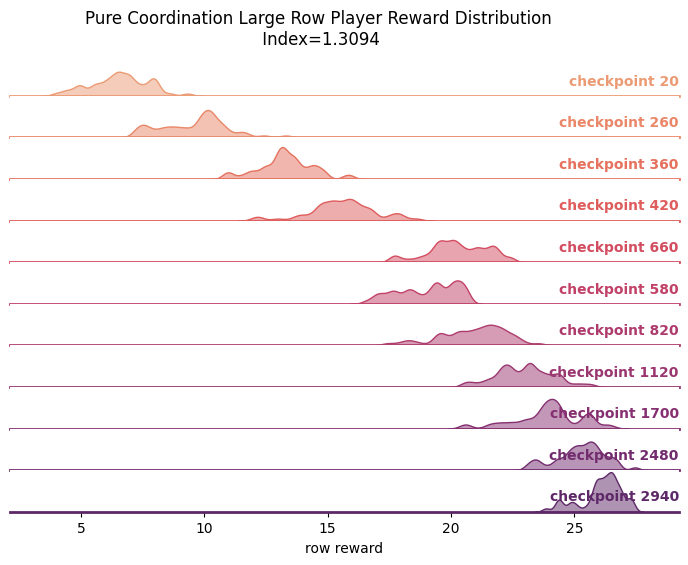

In [5]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [6]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint'])
new_df

,reward,label,checkpoint
0,7.442593,col,checkpoint 20
1,7.029079,col,checkpoint 20
2,7.978205,col,checkpoint 20
3,7.917190,col,checkpoint 20
4,6.645902,col,checkpoint 20
...,...,...,...
1095,24.386429,row,checkpoint 2940
1096,26.274206,row,checkpoint 2940
1097,25.116468,row,checkpoint 2940
1098,26.241544,row,checkpoint 2940


### Comparison Ridge Plot

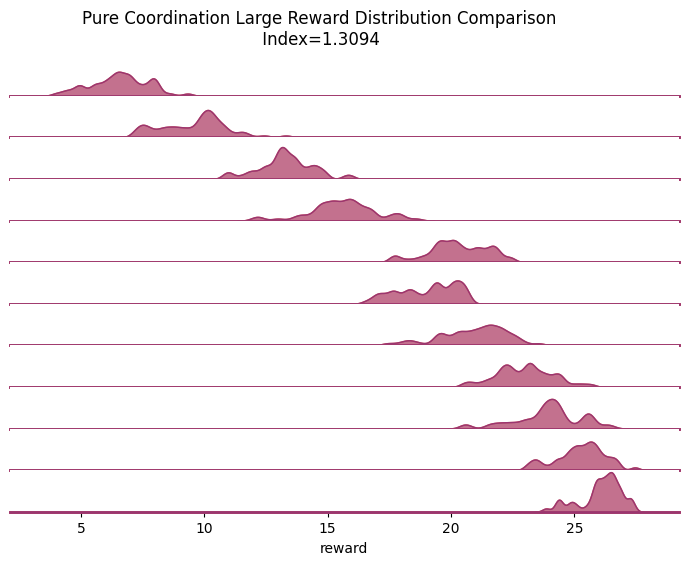

In [7]:
g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # ax.text(1, .2, label, fontweight="bold", color=color,
    #         ha="right", va="bottom", transform=ax.transAxes)
# def annotate(data, color, **kws):
#     n = data['checkpoint']
#     ax = plt.gca()
#     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "reward")
# g.map_dataframe(annotate)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Reward Distribution Comparison\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' distribution comparison.pdf'), bbox_inches='tight')